# Import Libraries

In [1]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency


# Data Description


Rows: ~6M

Source: https://scbpocseasta001stdsbx.z23.web.core.windows.net/

Columns:
- time_ind: หน่วยเวลาในการจำลอง (1 step = 1 ชั่วโมง; รวมทั้งหมด 744 steps = 30 วัน)
- transac_type: ประเภทของธุรกรรม (CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER)
- amount: จำนวนเงินของธุรกรรม (สกุลเงินท้องถิ่น)
- src_acc: บัญชีผู้ส่ง หรือผู้เริ่มธุรกรรม
- src_bal: ยอดเงินคงเหลือของผู้ส่งก่อนทำธุรกรรม
- src_new_bal: ยอดเงินคงเหลือของผู้ส่งหลังทำธุรกรรม
- dst_acc: บัญชีผู้รับ
- dst_bal: ยอดเงินคงเหลือของผู้รับก่อนทำธุรกรรม (ข้อมูลหายไปในกรณีเป็นร้านค้า)
- dst_new_bal: ยอดเงินคงเหลือของผู้รับหลังทำธุรกรรม (ข้อมูลหายไปในกรณีเป็นร้านค้า)
- is_fraud: ธุรกรรมที่เกิดจากผู้ทุจริต (เป็นตัวแปรเป้าหมาย)
- is_flagged_fraud: ธุรกรรมที่ถูกระบบกฎระบุว่าเข้าข่ายผิดกฎหมาย (เช่น โอนเงินเกิน 200,000 บาทต่อครั้ง)

Disclaimer: The dataset is mocked and may contain some discrepancies.

# Load Data and Exploratory Data Analysis (EDA)

In [2]:
zip_path = "../data/scbpocseasta001stdsbx.z23.web.core.windows.net"

with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files inside ZIP:")
    print(z.namelist())

    csv_name = [name for name in z.namelist() if name.endswith(".csv")][0]
    print("Reading:", csv_name)

    with z.open(csv_name) as f:
        df = pd.read_csv(f)

print("Loaded dataframe with shape:", df.shape)
df.head()


Files inside ZIP:
['fraud_mock.csv']
Reading: fraud_mock.csv
Loaded dataframe with shape: (6362620, 11)


,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,acc910286,170136.0,160296.36,acc298089,0.0,0.0,0,0
1,1,PAYMENT,1864.28,acc6597009,21249.0,19384.72,acc8726693,0.0,0.0,0,0
2,1,TRANSFER,181.00,acc1796908,181.0,0.00,acc4938640,0.0,0.0,1,0
3,1,CASH_OUT,181.00,acc4182296,181.0,0.00,acc1221153,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,acc7841596,41554.0,29885.86,acc5599142,0.0,0.0,0,0


In [ ]:
df_cashin = df[df['transac_type'] == 'CASH_IN'].copy()
df_cashout = df[df['transac_type'] == 'CASH_OUT'].copy()
df_debit = df[df['transac_type'] == 'DEBIT'].copy()
df_payment = df[df['transac_type'] == 'PAYMENT'].copy()
df_trans = df[df['transac_type'] == 'TRANSFER'].copy()

In [25]:
df_cashin

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
389,1,CASH_IN,143236.26,acc7330202,0.00,143236.26,acc1987097,608932.17,97263.78,0,0
390,1,CASH_IN,228451.89,acc8932833,143236.26,371688.15,acc4188747,719678.38,1186556.81,0,0
391,1,CASH_IN,35902.49,acc3846597,371688.15,407590.65,acc695950,49003.30,0.00,0,0
392,1,CASH_IN,232953.64,acc8135375,407590.65,640544.28,acc7610359,1172672.27,1517262.16,0,0
393,1,CASH_IN,65912.95,acc850529,640544.28,706457.23,acc8256665,104198.26,24044.18,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362253,718,CASH_IN,188888.89,acc786670,51838.00,240726.89,acc1081516,0.00,0.00,0,0
6362271,718,CASH_IN,27919.60,acc5113586,2413.00,30332.60,acc5001675,512791.59,484871.98,0,0
6362279,718,CASH_IN,78988.38,acc7084243,204464.00,283452.38,acc1144054,108724.19,29735.81,0,0
6362298,718,CASH_IN,18000.26,acc5417087,63409.00,81409.26,acc2845845,28088.61,10088.34,0,0


In [26]:
df_cashout

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
3,1,CASH_OUT,181.00,acc4182296,181.00,0.0,acc1221153,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,acc7697333,15325.00,0.0,acc2123864,5083.00,51513.44,0,0
42,1,CASH_OUT,110414.71,acc3528661,26845.41,0.0,acc526959,288800.00,2415.16,0,0
47,1,CASH_OUT,56953.90,acc240092,1942.02,0.0,acc3540823,70253.00,64106.18,0,0
48,1,CASH_OUT,5346.89,acc5693678,0.00,0.0,acc8532918,652637.00,6453430.91,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362611,742,CASH_OUT,63416.99,acc8824829,63416.99,0.0,acc3761079,276433.18,339850.17,1,0
6362613,743,CASH_OUT,1258818.82,acc3399412,1258818.82,0.0,acc236310,503464.50,1762283.33,1,0
6362615,743,CASH_OUT,339682.13,acc2163918,339682.13,0.0,acc8427994,0.00,339682.13,1,0
6362617,743,CASH_OUT,6311409.28,acc2707576,6311409.28,0.0,acc5785506,68488.84,6379898.11,1,0


In [27]:
df_debit

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
9,1,DEBIT,5337.77,acc9023241,41720.0,36382.23,acc7739610,41898.00,40348.79,0,0
10,1,DEBIT,9644.94,acc8462289,4465.0,0.00,acc2074279,10845.00,157982.12,0,0
21,1,DEBIT,9302.79,acc2305517,11299.0,1996.21,acc6275408,29832.00,16896.70,0,0
22,1,DEBIT,1065.41,acc4475575,1817.0,751.59,acc6988744,10330.00,0.00,0,0
41,1,DEBIT,5758.59,acc5488004,32604.0,26845.41,acc4251149,209699.00,16997.22,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362247,718,DEBIT,2063.08,acc1464502,328612.0,326548.92,acc774363,1312720.98,1314784.06,0,0
6362254,718,DEBIT,425.65,acc6968777,4046.0,3620.35,acc2256918,3009282.73,3009708.38,0,0
6362282,718,DEBIT,1636.03,acc689620,83120.0,81483.97,acc5870607,8393318.02,8394954.05,0,0
6362303,718,DEBIT,2148.99,acc1991279,49632.0,47483.01,acc9034486,66241.39,68390.38,0,0


In [28]:
df_payment

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,acc910286,170136.0,160296.36,acc298089,0.0,0.0,0,0
1,1,PAYMENT,1864.28,acc6597009,21249.0,19384.72,acc8726693,0.0,0.0,0,0
4,1,PAYMENT,11668.14,acc7841596,41554.0,29885.86,acc5599142,0.0,0.0,0,0
5,1,PAYMENT,7817.71,acc5327005,53860.0,46042.29,acc6516281,0.0,0.0,0,0
6,1,PAYMENT,7107.77,acc1424819,183195.0,176087.23,acc1553209,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362312,718,PAYMENT,8178.01,acc7540768,11742.0,3563.99,acc222706,0.0,0.0,0,0
6362314,718,PAYMENT,17841.23,acc8101832,10182.0,0.00,acc8572428,0.0,0.0,0,0
6362316,718,PAYMENT,1022.91,acc4518174,12.0,0.00,acc2621265,0.0,0.0,0,0
6362318,718,PAYMENT,4109.57,acc1737770,5521.0,1411.43,acc7632481,0.0,0.0,0,0


In [29]:
df_trans

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
2,1,TRANSFER,181.00,acc1796908,181.00,0.0,acc4938640,0.00,0.00,1,0
19,1,TRANSFER,215310.30,acc8579790,705.00,0.0,acc1511007,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,acc5249602,10835.00,0.0,acc5114175,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,acc4012568,79114.00,16503.2,acc6949288,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,acc1864260,10363.39,0.0,acc8256665,57901.66,24044.18,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362610,742,TRANSFER,63416.99,acc3732512,63416.99,0.0,acc3937672,0.00,0.00,1,0
6362612,743,TRANSFER,1258818.82,acc6201756,1258818.82,0.0,acc321735,0.00,0.00,1,0
6362614,743,TRANSFER,339682.13,acc7218468,339682.13,0.0,acc119005,0.00,0.00,1,0
6362616,743,TRANSFER,6311409.28,acc3367504,6311409.28,0.0,acc8883454,0.00,0.00,1,0


In [10]:
df[df['src_new_bal'] + df['amount'] != df['src_bal']]

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
8,1,PAYMENT,4024.36,acc5428218,2671.00,0.00,acc291243,0.00,0.00,0,0
10,1,DEBIT,9644.94,acc8462289,4465.00,0.00,acc2074279,10845.00,157982.12,0,0
13,1,PAYMENT,11633.76,acc3180839,10127.00,0.00,acc805084,0.00,0.00,0,0
15,1,CASH_OUT,229133.94,acc7697333,15325.00,0.00,acc2123864,5083.00,51513.44,0,0
16,1,PAYMENT,1563.82,acc4301678,450.00,0.00,acc667586,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362321,718,CASH_OUT,186273.84,acc7363205,168046.00,0.00,acc5852826,24893.67,211167.51,0,0
6362322,718,TRANSFER,82096.45,acc2793652,13492.00,0.00,acc6458429,0.00,82096.45,0,0
6362460,730,TRANSFER,10000000.00,acc8440130,17316255.05,17316255.05,acc3293748,0.00,0.00,1,1
6362462,730,TRANSFER,7316255.05,acc6151788,17316255.05,17316255.05,acc569313,0.00,0.00,1,1


In [12]:
df[df['src_new_bal'] + df['amount'] > df['src_bal']]

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
8,1,PAYMENT,4024.36,acc5428218,2671.00,0.00,acc291243,0.00,0.00,0,0
10,1,DEBIT,9644.94,acc8462289,4465.00,0.00,acc2074279,10845.00,157982.12,0,0
13,1,PAYMENT,11633.76,acc3180839,10127.00,0.00,acc805084,0.00,0.00,0,0
15,1,CASH_OUT,229133.94,acc7697333,15325.00,0.00,acc2123864,5083.00,51513.44,0,0
16,1,PAYMENT,1563.82,acc4301678,450.00,0.00,acc667586,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362321,718,CASH_OUT,186273.84,acc7363205,168046.00,0.00,acc5852826,24893.67,211167.51,0,0
6362322,718,TRANSFER,82096.45,acc2793652,13492.00,0.00,acc6458429,0.00,82096.45,0,0
6362460,730,TRANSFER,10000000.00,acc8440130,17316255.05,17316255.05,acc3293748,0.00,0.00,1,1
6362462,730,TRANSFER,7316255.05,acc6151788,17316255.05,17316255.05,acc569313,0.00,0.00,1,1


In [11]:
df[df['src_new_bal'] + df['amount'] < df['src_bal']]

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
38,1,PAYMENT,7413.54,acc1588600,297689.58,290276.03,acc6355298,0.00,0.00,0,0
63,1,PAYMENT,2599.46,acc1399466,874042.26,871442.79,acc2130660,0.00,0.00,0,0
71,1,CASH_OUT,136872.92,acc6444185,162075.98,25203.05,acc1569849,217806.00,0.00,0,0
245,1,PAYMENT,3199.06,acc907748,6299171.25,6295972.18,acc6180916,0.00,0.00,0,0
304,1,PAYMENT,3852.64,acc1402254,1449076.27,1445223.63,acc429665,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6355453,709,CASH_OUT,180102.15,acc7707000,196409.41,16307.25,acc1500602,199552.77,379654.92,0,0
6355715,709,PAYMENT,753.04,acc4711683,112403.69,111650.65,acc8739995,0.00,0.00,0,0
6355943,709,PAYMENT,2913.82,acc1626228,49971.42,47057.59,acc2019068,0.00,0.00,0,0
6355945,709,PAYMENT,3316.46,acc7152967,31282.81,27966.35,acc8125650,0.00,0.00,0,0


In [13]:
df[df['src_bal'] + df['dst_bal'] != df['src_new_bal'] + df['dst_new_bal']]

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,acc910286,170136.00,160296.36,acc298089,0.00,0.00,0,0
1,1,PAYMENT,1864.28,acc6597009,21249.00,19384.72,acc8726693,0.00,0.00,0,0
2,1,TRANSFER,181.00,acc1796908,181.00,0.00,acc4938640,0.00,0.00,1,0
3,1,CASH_OUT,181.00,acc4182296,181.00,0.00,acc1221153,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,acc7841596,41554.00,29885.86,acc5599142,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362614,743,TRANSFER,339682.13,acc7218468,339682.13,0.00,acc119005,0.00,0.00,1,0
6362616,743,TRANSFER,6311409.28,acc3367504,6311409.28,0.00,acc8883454,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,acc2707576,6311409.28,0.00,acc5785506,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,acc2903623,850002.52,0.00,acc6726745,0.00,0.00,1,0


จากการทดสอบสมการบัญชีของฝั่งผู้ส่ง
src_bal = src_new_bal + amount
พบว่าหลายธุรกรรมไม่เป็นไปตามสมการ เช่น
ยอดก่อน (src_bal) มากกว่า 0 แต่ยอดหลัง (src_new_bal) กลายเป็น 0
หรือบางกรณีมียอดหลังมากกว่ายอดก่อน ซึ่งไม่สมเหตุสมผลทางบัญชี

นอกจากนี้เมื่อตรวจสอบยอดรวมทั้งระบบ
src_bal + dst_bal ≠ src_new_bal + dst_new_bal
พบความไม่สมดุลในหลายกรณี โดยเฉพาะธุรกรรมประเภท PAYMENT
ซึ่งมีค่า 0 ในฝั่งผู้รับแทนค่าที่หายไป (missing)

In [39]:
df.isna().sum().sort_values(ascending=False)


time_ind            0
transac_type        0
amount              0
src_acc             0
src_bal             0
src_new_bal         0
dst_acc             0
dst_bal             0
dst_new_bal         0
is_fraud            0
is_flagged_fraud    0
dtype: int64

จากผลการตรวจสอบ Missing Value พบว่าไม่มี Missing Value อยู่เลย แต่เมื่อเทียบกับคำอธิบายข้อมูล พบว่า dst_bal และ dst_new_bal
ถูกระบุว่า “missing for merchants” ซึ่งตรงกับธุรกรรมประเภท PAYMENT เมื่อดูตัวอย่างข้อมูลพบว่า ธุรกรรม PAYMENT ทั้งหมดมีค่า dst_bal และ dst_new_bal เป็น 0.0 ซึ่งไม่ได้หมายถึงยอดเงิน 0 บาทจริง ๆ แต่หมายถึง ไม่มีข้อมูล (missing) แต่ระบบบันทึกแทนด้วย 0

ดังนั้นจึงสรุปได้ว่า ข้อมูลชุดนี้มี missing value ที่ถูกแทนด้วย 0 โดยเฉพาะในธุรกรรมประเภท PAYMENT ซึ่งมีมากกว่า 2 ล้านรายการ หากไม่จัดการก่อนวิเคราะห์ต่อไป จะทำให้ผลทางสถิติเพี้ยน เช่น กราฟกระจุกที่ศูนย์ หรือค่า p-value ของฟีเจอร์ที่เกี่ยวข้องสูงผิดปกติ จึงจะเปลี่ยนค่า 0 ใน dst_bal และ dst_new_bal ของธุรกรรม PAYMENT ให้เป็น NaN ก่อนการวิเคราะห์ เพื่อให้สถิติสอดคล้องกับความจริงของข้อมูล

In [30]:
print("--- ก่อนการแก้ไข ---")
print(f"จำนวน Missing (NaN) ใน dst_bal (ก่อนแก้): {df['dst_bal'].isna().sum()}")
print(f"จำนวนธุรกรรม PAYMENT ที่ dst_bal เป็น 0: {len(df[(df['transac_type'] == 'PAYMENT') & (df['dst_bal'] == 0)])}")

payment_indices = df[df['transac_type'] == 'PAYMENT'].index

df.loc[payment_indices, ['dst_bal', 'dst_new_bal']] = np.nan

print("\n--- หลังการแก้ไข ---")
print(f"จำนวน Missing (NaN) ใน dst_bal (หลังแก้): {df['dst_bal'].isna().sum()}")
print(f"จำนวนธุรกรรม PAYMENT ที่ dst_bal เป็น 0 (หลังแก้): {len(df[(df['transac_type'] == 'PAYMENT') & (df['dst_bal'] == 0)])}")

--- ก่อนการแก้ไข ---
จำนวน Missing (NaN) ใน dst_bal (ก่อนแก้): 0
จำนวนธุรกรรม PAYMENT ที่ dst_bal เป็น 0: 2151495

--- หลังการแก้ไข ---
จำนวน Missing (NaN) ใน dst_bal (หลังแก้): 2151495
จำนวนธุรกรรม PAYMENT ที่ dst_bal เป็น 0 (หลังแก้): 0


In [31]:
df.isna().sum().sort_values(ascending=False)


dst_bal             2151495
dst_new_bal         2151495
time_ind                  0
transac_type              0
amount                    0
src_acc                   0
src_bal                   0
src_new_bal               0
dst_acc                   0
is_fraud                  0
is_flagged_fraud          0
dtype: int64

In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   time_ind          int64  
 1   transac_type      object 
 2   amount            float64
 3   src_acc           object 
 4   src_bal           float64
 5   src_new_bal       float64
 6   dst_acc           object 
 7   dst_bal           float64
 8   dst_new_bal       float64
 9   is_fraud          int64  
 10  is_flagged_fraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


**ผลลัพธ์:**
ข้อมูลมีทั้งหมด 6,362,620 แถว และ 11 คอลัมน์ โดยแบ่งชนิดข้อมูลได้เป็น
- จำนวนจริง (float64) = 5 คอลัมน์
- จำนวนเต็ม (int64) = 3 คอลัมน์
- ข้อความ (object) = 3 คอลัมน์

In [34]:
df.describe(include='all')

,time_ind,transac_type,amount,src_acc,src_bal,src_new_bal,dst_acc,dst_bal,dst_new_bal,is_fraud,is_flagged_fraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,4.211125e+06,4.211125e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,acc8073602,NaN,NaN,acc535694,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.663058e+06,1.850856e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,4.064780e+06,4.386080e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,1.396590e+05,2.217176e+05,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,5.512472e+05,6.837248e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,1.692951e+06,1.910979e+06,0.000000e+00,0.000000e+00


In [35]:
df.nunique()

time_ind                743
transac_type              5
amount              5316900
src_acc             6353307
src_bal             1845844
src_new_bal         2682586
dst_acc             2722362
dst_bal             3614697
dst_new_bal         3555499
is_fraud                  2
is_flagged_fraud          2
dtype: int64

Typically if the numer of unique values are < 20 then the variable is likely to be a category otherwise continuous

- Continuous (ตัวเลขเชิงปริมาณ): amount, src_bal, src_new_bal, dst_bal, dst_new_bal
- Categorical (กลุ่ม/ประเภท): transac_type, is_flagged_fraud
- Temporal/Sequential (เชิงเวลา): time_ind (มี 743 steps)
- Identifier (รหัสบัญชี): src_acc, dst_acc (High-cardinality)
- Target: is_fraud

# Target Variable Analysis

In [39]:
df['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

จากผลลัพธ์พบว่าข้อมูล Imbalanced มาก (Fraud 0.129%)

# Bivariate Analysis: Features vs. Target

In [43]:
categorical_features = ['transac_type', 'is_flagged_fraud']
continuous_features = ['amount', 'src_bal', 'src_new_bal', 'dst_bal', 'dst_new_bal']
target = 'is_fraud'

## Categorical Features vs. Target

### Visualize distribution of all the Categorical Predictor variables in the data using bar plots


ในส่วนนี้จะแสดงการกระจายตัวของตัวแปรเชิงหมวดหมู่ทั้งหมด (transac_type, is_flagged_fraud) โดยใช้ Bar plots

เป้าหมายคือเพื่อทำความเข้าใจลักษณะของแต่ละฟีเจอร์:

- transac_type: เพื่อดูความถี่ของธุรกรรมแต่ละประเภท

- is_flagged_fraud: เพื่อยืนยันว่าฟีเจอร์นี้มีการใช้งานจริงมากน้อยแค่ไหน


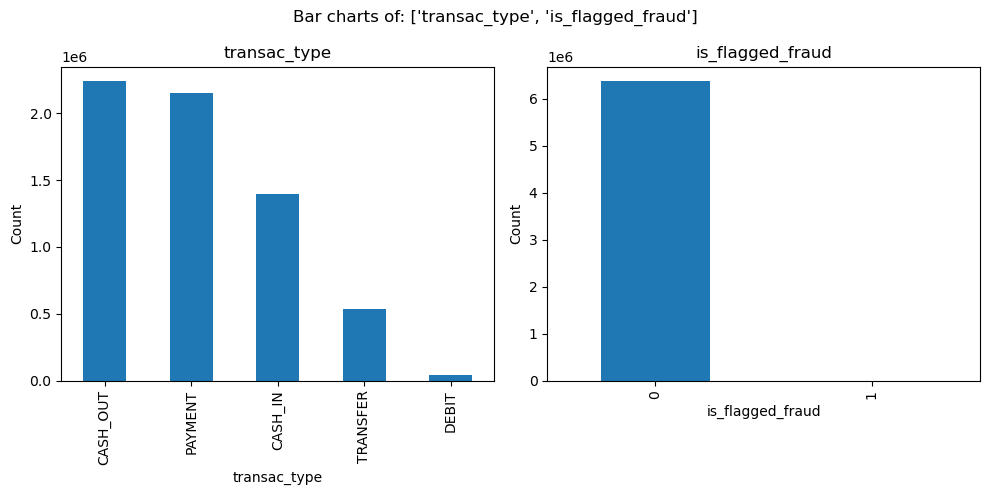

In [44]:
def plot_bar_charts(inpData, colsToPlot):
    fig, subPlot = plt.subplots(nrows=1, ncols=len(colsToPlot), figsize=(10, 5))
    fig.suptitle('Bar charts of: ' + str(colsToPlot))

    if len(colsToPlot) == 1:
        subPlot = [subPlot]

    for colName, plotNumber in zip(colsToPlot, range(len(colsToPlot))):
        inpData[colName].value_counts().plot(kind='bar', ax=subPlot[plotNumber])
        subPlot[plotNumber].set_title(colName)
        subPlot[plotNumber].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

plot_bar_charts(inpData=df, colsToPlot=categorical_features)

### Visual exploration - Grouped Bar Plots or Stacked Bar Plot

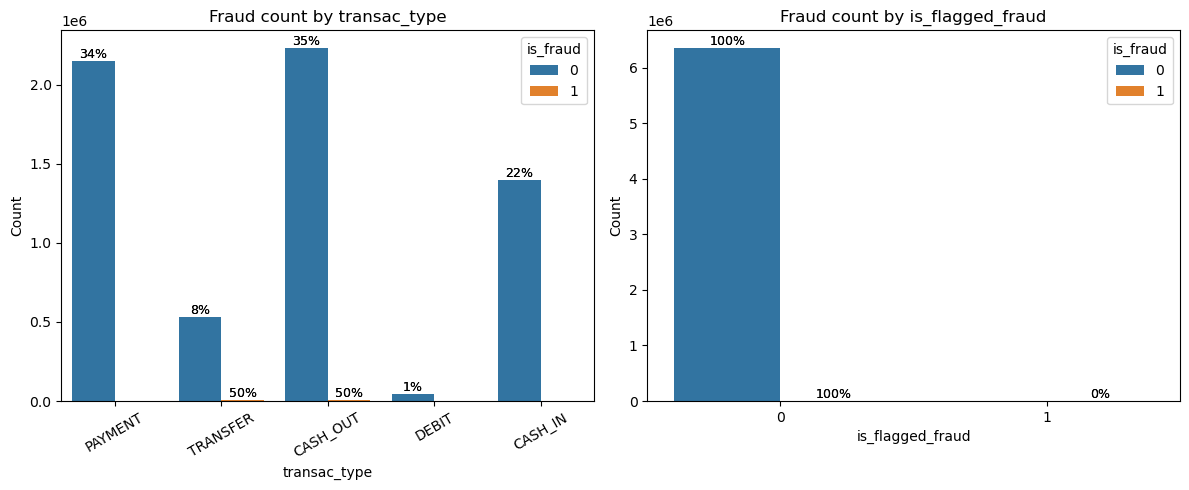

In [47]:
fig, axes = plt.subplots(1, len(categorical_features), figsize=(12, 5))

for i, col in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data=df, x=col, hue=target, ax=ax)

    ax.set_title(f"Fraud count by {col}")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=30 if col == 'transac_type' else 0)

    total_counts = df.groupby(col)[target].count()
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            group_value = p.get_x() + p.get_width() / 2
            category = p.get_x() + p.get_width() / 2
            x_val = p.get_x() + p.get_width() / 2
            cat = p.get_x() + p.get_width() / 2
    totals = df.groupby(col)[target].value_counts(normalize=True).unstack().fillna(0)

    for container in ax.containers:
        labels = []
        for bar in container:
            group_name = bar.get_x() + bar.get_width() / 2
        for c in ax.containers:
            ax.bar_label(c, fmt=lambda x: f'{x / sum([b.get_height() for b in c]):.0%}', label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()


### Statistical Feature Selection - Chi-Square test or Mutual information

In [49]:
chi2_rows = []

for col in categorical_features:
    contingency = pd.crosstab(df[col], df[target])
    if contingency.empty:
        continue
    
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.values.sum()
    r, c = contingency.shape
    k = min(r - 1, c - 1)
    
    phi2 = chi2 / n if n > 0 else np.nan
    cramers_v = np.sqrt(phi2 / k) if k > 0 else np.nan
    
    chi2_rows.append({
        "Feature": col,
        "Test": "Chi-square",
        "Statistic": chi2,
        "p-value": p,
        "DoF": dof,
        "Effect Size (Cramér's V)": cramers_v,
        "N": n
    })

chi2_df = pd.DataFrame(chi2_rows).sort_values("p-value").reset_index(drop=True)

chi2_df.style.format({
    "Statistic": "{:.3f}",
    "p-value": "{:.3e}",
    "Effect Size (Cramér's V)": "{:.3f}",
    "N": "{:,}"
})


,Feature,Test,Statistic,p-value,DoF,Effect Size (Cramér's V),N
0,transac_type,Chi-square,22082.536,0.000e+00,4,0.059,"6,362,620"
1,is_flagged_fraud,Chi-square,11616.666,0.000e+00,1,0.043,"6,362,620"


**การวิเคราะห์ข้อมูล Categorical Features**

1. transac_type (ประเภทธุรกรรม)

    - ผลการสังเกต:
    จากกราฟ Fraud count by Transaction Type พบว่าการทุจริต (แท่งสีส้ม) เกิดขึ้นเฉพาะในธุรกรรมประเภท TRANSFER และ CASH_OUT เท่านั้น โดยทั้งสองประเภทมีสัดส่วนการโกงใกล้เคียงกัน (ประมาณ 50% ต่อประเภท)
    ในขณะที่ธุรกรรมประเภทอื่น เช่น PAYMENT, DEBIT, และ CASH_IN ซึ่งรวมกันคิดเป็นกว่า 57% ของข้อมูลทั้งหมด (34% + 1% + 22%) ไม่มีธุรกรรมที่เป็นการโกงเลย

    - ผลการทดสอบทางสถิติ:
    ผลการทดสอบ Chi-Square พบค่า p-value ต่ำกว่า 0.05 แสดงว่าประเภทธุรกรรมมีความสัมพันธ์กับการเกิดการโกงอย่างมีนัยสำคัญทางสถิติ

    - สรุป:
    ฟีเจอร์ transac_type มีความสัมพันธ์ต่อการเกิด Fraud อย่างชัดเจน และถือเป็นตัวแปรสำคัญที่ควรรวมไว้ในการสร้างโมเดลทำนายการโกง

2. is_flagged_fraud (การถูก Flag โดยระบบ)

    - ผลการสังเกต:
    จากกราฟพบว่าธุรกรรมเกือบทั้งหมด (มากกว่า 6 ล้านรายการ) อยู่ในกลุ่มที่ is_flagged_fraud = 0 หรือ “ไม่ถูก Flag” โดยทั้งธุรกรรมปกติและธุรกรรมโกงต่างก็อยู่ในกลุ่มนี้ทั้งหมด

    - ผลการทดสอบทางสถิติ:
    แม้ค่า p-value จากการทดสอบ Chi-Square จะมีนัยสำคัญทางสถิติ (p ≈ 0.000) แต่ในเชิงปฏิบัติกลับไม่ช่วยแยกแยะธุรกรรมโกงได้ เพราะทุกเคสของการโกงจริงอยู่ในกลุ่มที่ไม่ถูก Flag ทั้งหมด

    - สรุป:
    แม้ฟีเจอร์ is_flagged_fraud จะมีความแตกต่างเชิงสถิติ แต่ไม่สามารถใช้บ่งชี้หรือทำนายพฤติกรรมการโกงได้ในทางปฏิบัติ จึงจะขอ Doubt (เก็บไว้พิจารณาตัดทิ้ง) ไว้ก่อน

## Continuous Features vs. Target

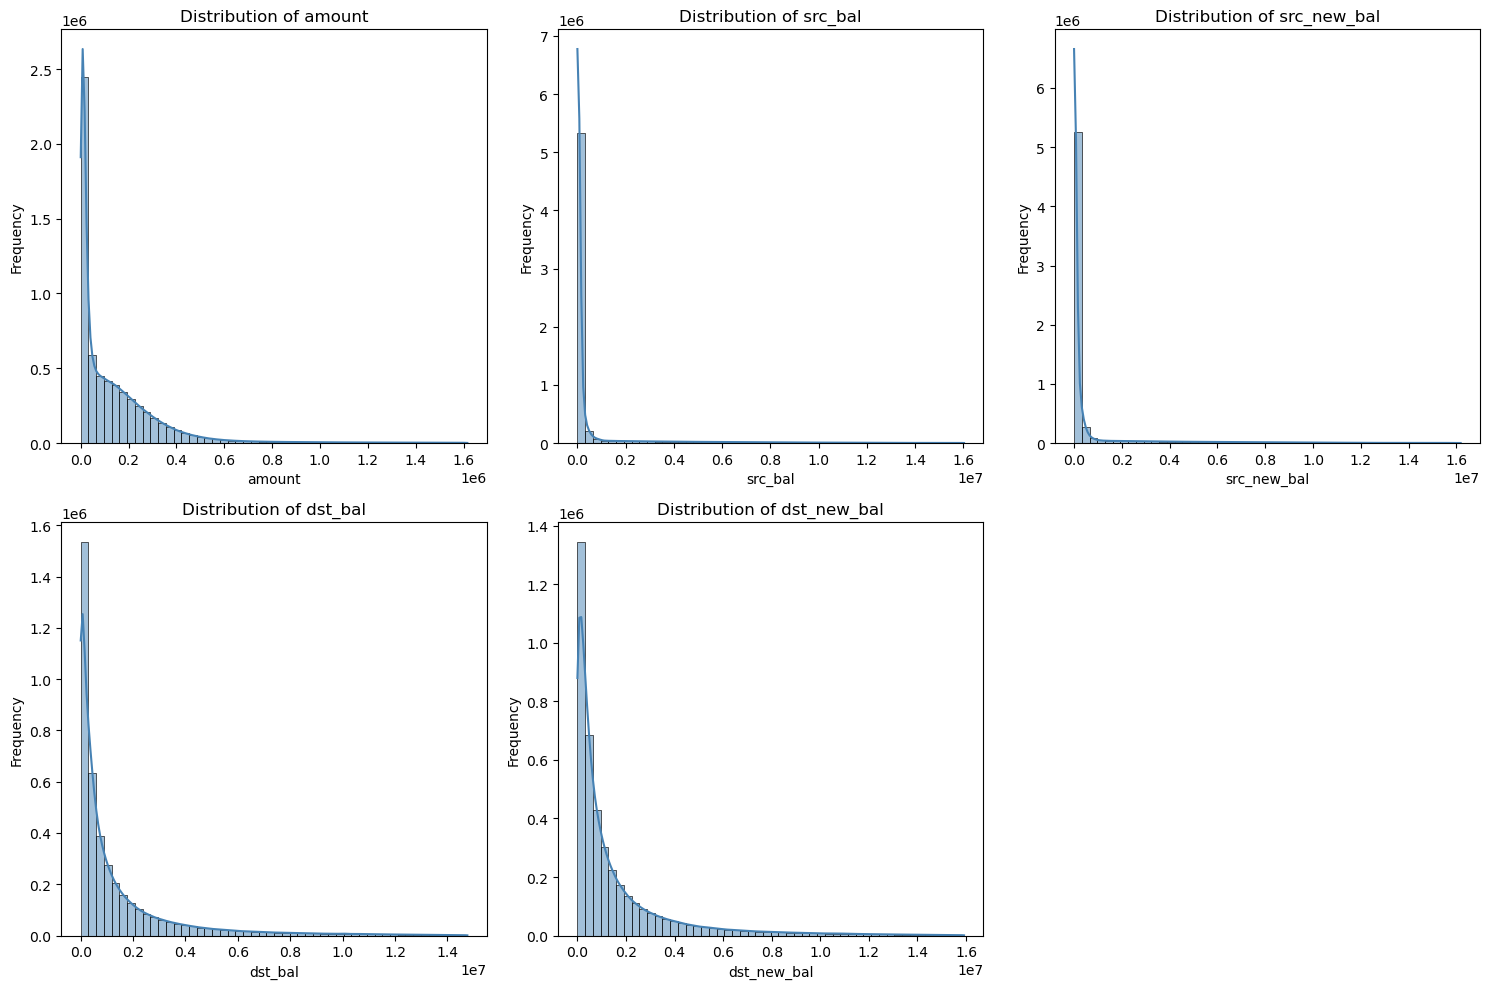

In [ ]:
continuous_features = ['amount', 'src_bal', 'src_new_bal', 'dst_bal', 'dst_new_bal']

plt.figure(figsize=(15, 10))

for i, col in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)

    # ตัด outlier ที่เกิน percentile 99
    upper_limit = df[col].quantile(0.99)
    filtered_data = df[df[col] <= upper_limit][col]

    sns.histplot(filtered_data, bins=50, kde=True, color='steelblue')

    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


จากการวิเคราะห์ค่าต่อเนื่องทั้งหมด พบว่ามีการกระจายแบบเบ้ขวา (right-skewed) สูง จึงทำการแปลงค่าเชิงลอการิทึม (log-transform) เพื่อให้ข้อมูลใกล้การแจกแจงปกติและลดอิทธิพลของค่าผิดปกติ จากนั้นจึงใช้ boxplot และการทดสอบ ANOVA เพื่อเปรียบเทียบค่ากลางระหว่างธุรกรรมปกติและธุรกรรมที่เป็นการฉ้อโกง ผลลัพธ์แสดงให้เห็นว่าหลายฟีเจอร์มีความแตกต่างอย่างมีนัยสำคัญทางสถิติ (p-value < 0.05) ซึ่งบ่งชี้ว่าฟีเจอร์เหล่านี้อาจมีประโยชน์ต่อการจำแนกการฉ้อโกง

Histogram (log scale)

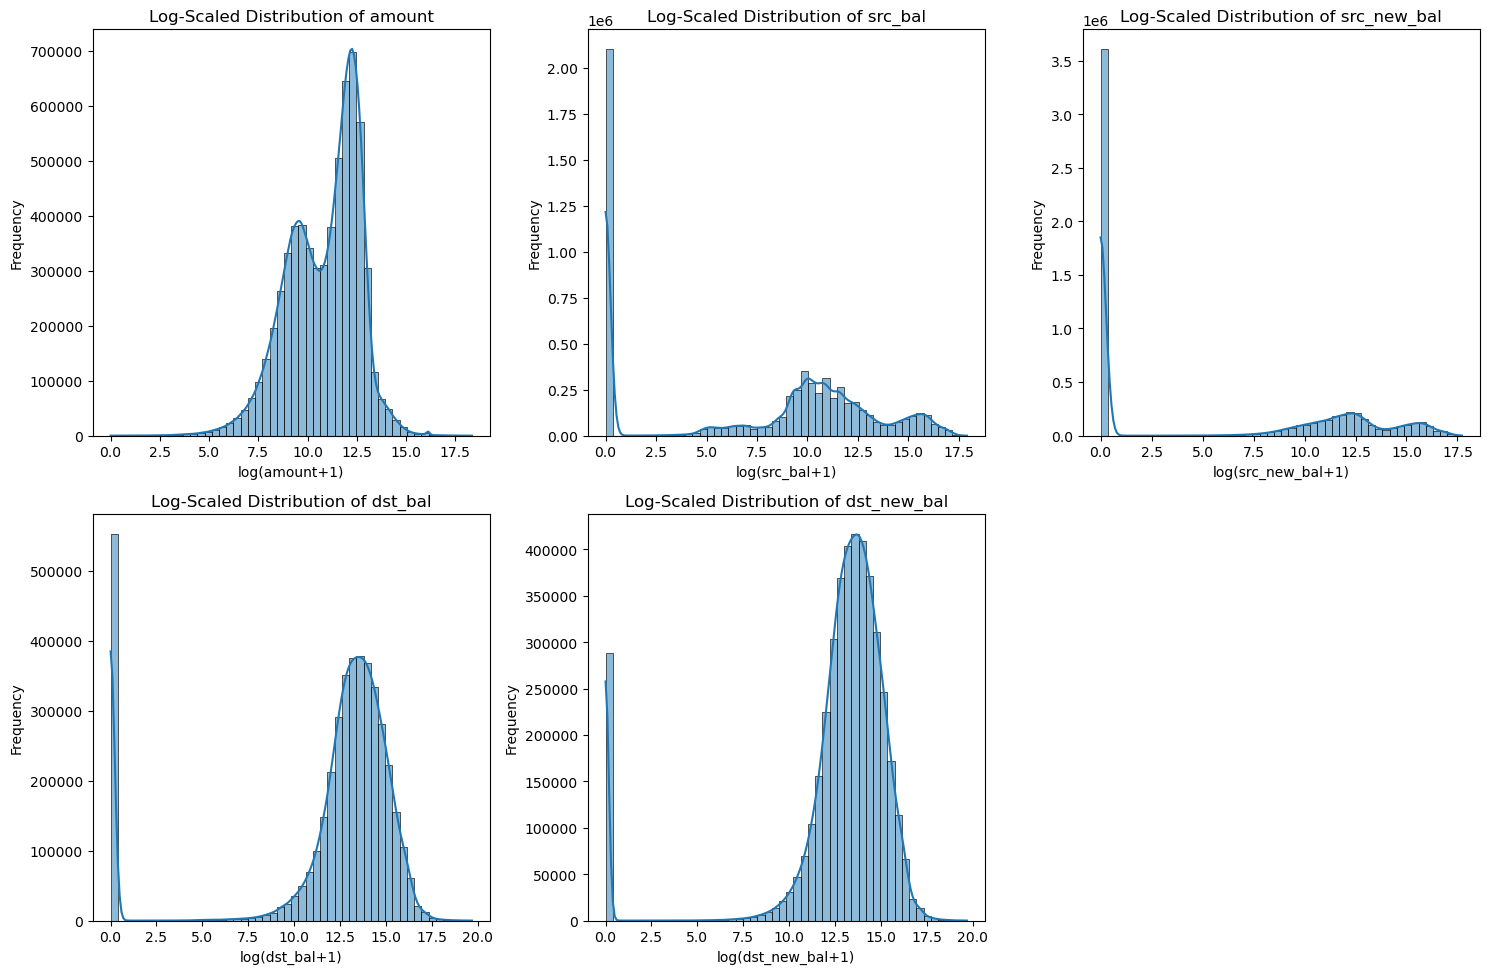

In [57]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(np.log1p(df[col]), bins=50, kde=True)
    plt.title(f"Log-Scaled Distribution of {col}")
    plt.xlabel(f"log({col}+1)")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Boxplot (รวมทุก feature)

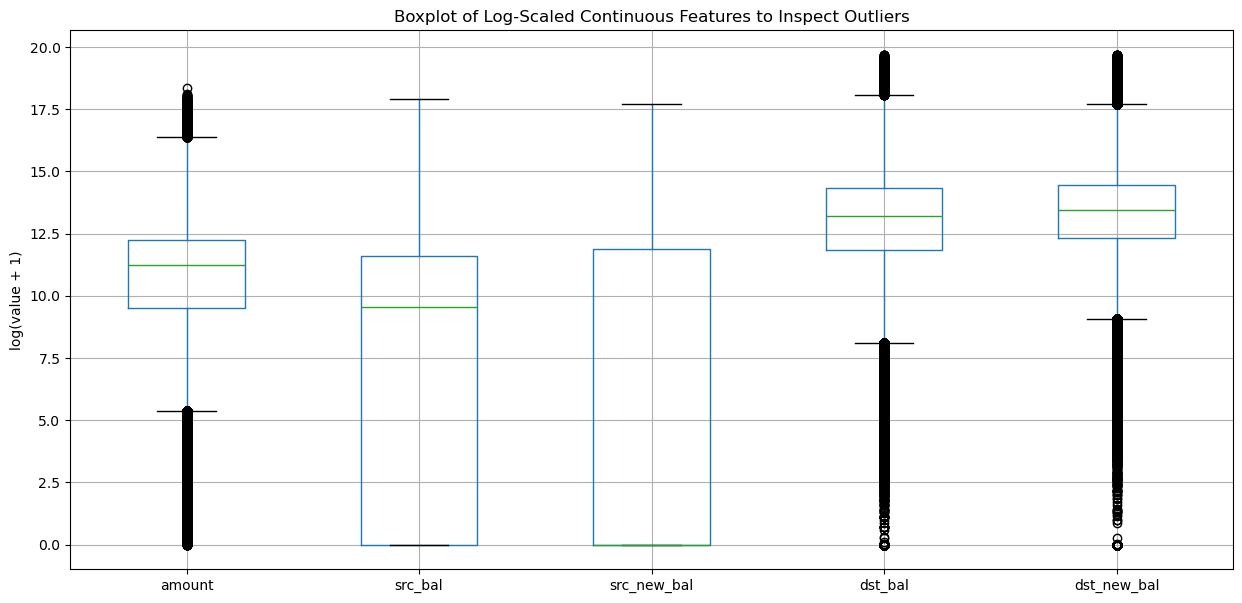

In [58]:
pd.DataFrame({col: np.log1p(df[col]) for col in continuous_features}).boxplot(figsize=(15,7))
plt.title("Boxplot of Log-Scaled Continuous Features to Inspect Outliers")
plt.ylabel("log(value + 1)")
plt.show()

**วิเคราะห์การกระจายของข้อมูล (จาก Histogram Log-Scale และ Boxplot)**

ในภาพรวมพบว่าหลังแปลง log (log(x+1)) ทุกฟีเจอร์มีการกระจายแคบลงและสามารถเห็นรูปแบบชัดเจนขึ้น ค่ามากสุด (outlier) ยังมีอยู่บ้าง แต่ไม่ส่งผลรุนแรงเท่าค่าดิบ และในส่วนของการวิเคราะห์รายฟีเจอร์สามารถสรุปได้ดงนี้
- amount: กระจายใกล้ log-normal มีค่ากลางประมาณ 10–12
- src_bal, src_new_bal: มีสองกลุ่มชัด (บางบัญชีมีเงินคงเหลือ 0 และบางบัญชีมีหลักล้าน)
- dst_bal, dst_new_bal: รูปร่างใกล้ normal หลัง log แสดงว่าผู้รับส่วนใหญ่มี balance อยู่ในช่วงกลาง

Boxplot แยกตาม Target

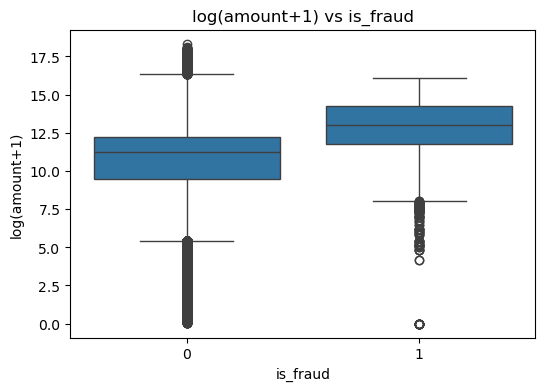

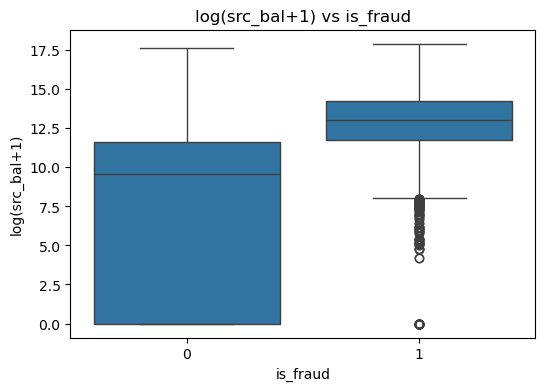

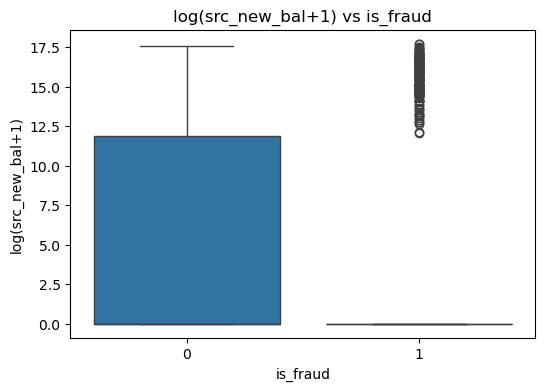

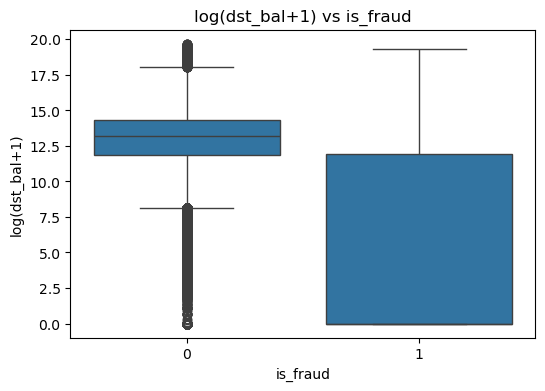

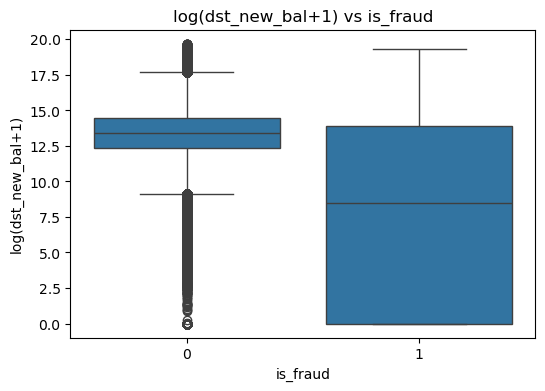

In [61]:
for col in continuous_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[target], y=np.log1p(df[col]))
    plt.title(f'log({col}+1) vs {target}')
    plt.xlabel(target)
    plt.ylabel(f'log({col}+1)')
    plt.show()

จากการสังเกตแต่ละฟีเจอร์ สามารถสรุปผลได้ดังนี้
- amount:
ธุรกรรมที่เป็น fraud มีค่าเฉลี่ย (median) สูงกว่าธรรมดา → แสดงว่า fraud มักเกี่ยวข้องกับยอดเงินที่มากกว่า
- src_bal / src_new_bal:
บัญชีที่เป็น fraud มักมี src_bal สูง (มีเงินให้ถอน/โอนออกได้) และหลังทำรายการ (src_new_bal) เหลือเกือบศูนย์
→ สะท้อนพฤติกรรม “ถอนหรือโอนออกจนหมดบัญชี”
- dst_bal / dst_new_bal:
บัญชีปลายทางของธุรกรรม fraud มักมี dst_bal หรือ dst_new_bal ต่ำก่อนหน้า แล้วเพิ่มขึ้นหลังธุรกรรม
→ สอดคล้องกับบัญชีรับโอนที่เพิ่งถูกใช้

ANOVA (เปรียบเทียบระหว่าง Fraud vs Non-Fraud)

In [62]:
anova_rows = []
for col in continuous_features:
    g1 = np.log1p(df.loc[df[target] == 1, col].dropna())
    g0 = np.log1p(df.loc[df[target] == 0, col].dropna())
    if len(g1) == 0 or len(g0) == 0:
        continue
    F, p = f_oneway(g1, g0)
    N = len(g1) + len(g0)
    eta_sq = (F * 1) / (F * 1 + (N - 2)) if N > 2 else np.nan
    anova_rows.append([col, "ANOVA (log1p)", F, p, f"1, {N-2}", eta_sq, N])

anova_df = pd.DataFrame(anova_rows, columns=["Feature","Test","Statistic","p-value","DoF","Effect Size","N"])\
             .sort_values("p-value").reset_index(drop=True)

anova_df.style.format({
    "Statistic": "{:.3f}",
    "p-value": "{:.3e}",
    "Effect Size": "{:.3f}",
    "N": "{:,}"
})


,Feature,Test,Statistic,p-value,DoF,Effect Size,N
0,amount,ANOVA (log1p),10525.874,0.000e+00,"1, 6362618",0.002,"6,362,620"
1,src_bal,ANOVA (log1p),7608.528,0.000e+00,"1, 6362618",0.001,"6,362,620"
2,src_new_bal,ANOVA (log1p),5267.237,0.000e+00,"1, 6362618",0.001,"6,362,620"
3,dst_bal,ANOVA (log1p),18770.932,0.000e+00,"1, 4211123",0.004,"4,211,125"
4,dst_new_bal,ANOVA (log1p),19385.378,0.000e+00,"1, 4211123",0.005,"4,211,125"


- ค่า p-value < 0.05 สำหรับทุกฟีเจอร์ (ในกรณีที่ผ่านการทำ log มาแล้ว) หมายความว่าค่าเฉลี่ยของแต่ละฟีเจอร์ แตกต่างกันระหว่างกลุ่ม fraud และ non-fraud อย่างมีนัยสำคัญ
- ค่า Effect Size (η²) อยู่ในช่วง 0.001–0.005 → ถือว่า ขนาดผลเล็กถึงปานกลาง
(ธรรมดาสำหรับ dataset ใหญ่ระดับ 6 ล้านรายการ — แม้ค่าผลกระทบเล็กแต่มีนัยสำคัญจริง)

**สรุป:**
การทดสอบ ANOVA แสดงให้เห็นว่าฟีเจอร์เชิงตัวเลขทั้งหมด (amount, src_bal, src_new_bal, dst_bal, dst_new_bal)
มีค่าเฉลี่ยแตกต่างกันระหว่างธุรกรรมปกติและธุรกรรมที่เป็นการฉ้อโกงอย่างมีนัยสำคัญทางสถิติ (p < 0.05)
โดยเฉพาะ dst_bal และ dst_new_bal ซึ่งมีค่า Effect Size สูงสุด
สะท้อนให้เห็นว่าพฤติกรรมของบัญชีปลายทางมีบทบาทสำคัญต่อการจำแนกธุรกรรมฉ้อโกง
ขณะที่ amount และ src_bal ก็มีแนวโน้มสูงกว่าในธุรกรรม fraud เช่นกัน

## Temporal Feature vs. Target

In [65]:
df['hour_of_day'] = df['time_ind'] % 24
print("Created hour_of_day (0–23) for EDA only.")

Created hour_of_day (0–23) for EDA only.


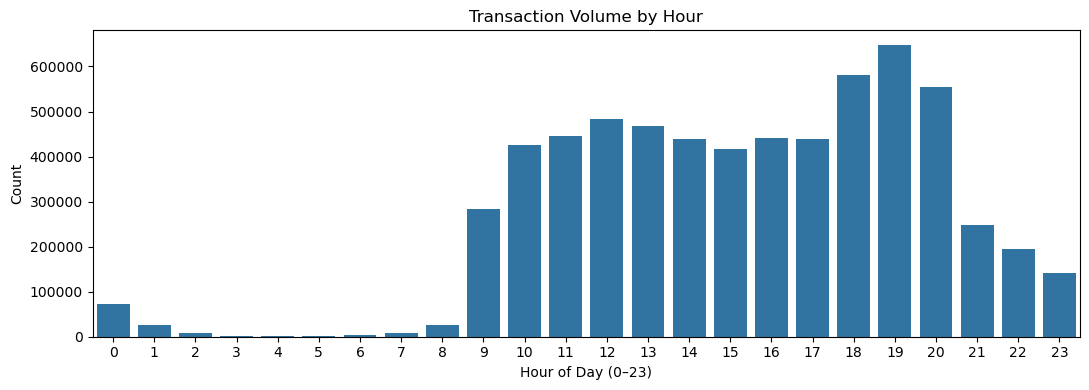

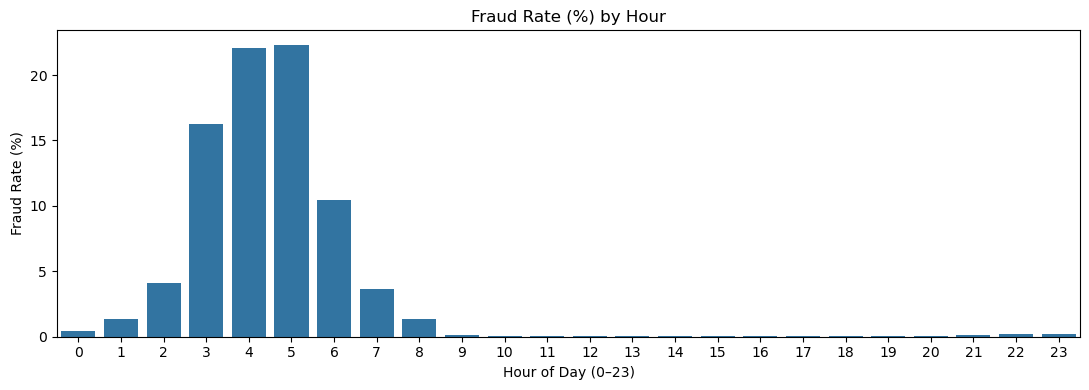

In [67]:
# ธุรกรรมทั้งหมดต่อชั่วโมง (ป้องกัน base-rate fallacy)
tx_per_hour = df['hour_of_day'].value_counts().sort_index()

# Fraud rate (%) ต่อชั่วโมง: mean ของ is_fraud (เพราะเป็น {0,1})
fraud_rate_by_hour = df.groupby('hour_of_day')['is_fraud'].mean().reindex(range(24), fill_value=0) * 100

# Plot 1: ปริมาณธุรกรรมต่อชั่วโมง
plt.figure(figsize=(11,4))
sns.barplot(x=tx_per_hour.index, y=tx_per_hour.values)
plt.title('Transaction Volume by Hour')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Count')
plt.xticks(range(24))
plt.tight_layout()
plt.show()

# Plot 2: สัดส่วน Fraud (%) ต่อชั่วโมง
plt.figure(figsize=(11,4))
sns.barplot(x=fraud_rate_by_hour.index, y=fraud_rate_by_hour.values)
plt.title('Fraud Rate (%) by Hour')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Fraud Rate (%)')
plt.xticks(range(24))
plt.tight_layout()
plt.show()


**วิเคราะห์จากกราฟ**
1. ภาพรวมปริมาณธุรกรรม (Transaction Volume by Hour)
ปริมาณธุรกรรมเพิ่มขึ้นอย่างชัดเจนในช่วง 09.00–20.00 น.
สะท้อนพฤติกรรมผู้ใช้ทั่วไปที่ทำธุรกรรมช่วงเวลาทำงาน
หลังจากนั้นปริมาณธุรกรรมลดลงอย่างมาก โดยเฉพาะช่วง 01.00-08.00 น.
แสดงให้เห็นว่าเป็นช่วงที่ระบบมีธุรกรรมค่อนข้างน้อย (off-peak)

2. อัตราการโกง (Fraud Rate (%) by Hour)
พบจุดพีคของการโกงชัดเจนในช่วงเวลา 04.00-05.00 น. ที่ Fraud rate พุ่งสูงกว่า 20% ในบางชั่วโมง ทั้งที่จำนวนธุรกรรมน้อยมาก
แปลว่าแม้จะมีธุรกรรมไม่เยอะ แต่สัดส่วนการโกงสูงมาก และหลังจาก 07.00 น. เป็นต้นไป Fraud rate ลดลงแทบจะเป็นศูนย์
สะท้อนว่าการโกงมักเกิดในช่วงกลางคืนหรือเช้ามืด

In [68]:
cont_hour = pd.crosstab(df['hour_of_day'], df['is_fraud']).reindex(index=range(24), fill_value=0)

chi2, p, dof, expected = chi2_contingency(cont_hour)
N = cont_hour.values.sum()

k, r = cont_hour.shape[0], cont_hour.shape[1]
cramers_v = np.sqrt(chi2 / (N * (min(k-1, r-1))))

print(f"Chi-square = {chi2:,.2f}, p-value = {p:.3e}, DoF = {dof}, Cramér's V = {cramers_v:.3f}")

resid_std = (cont_hour - expected) / np.sqrt(expected)
resid_fraud1 = resid_std[1].rename('std_resid_fraud=1')
top_hi = resid_fraud1.sort_values(ascending=False).head(5)
top_lo = resid_fraud1.sort_values(ascending=True).head(5)

print("\nHours with higher-than-expected fraud (top +residuals):")
print(top_hi.to_string())

print("\nHours with lower-than-expected fraud (top -residuals):")
print(top_lo.to_string())


Chi-square = 205,808.06, p-value = 0.000e+00, DoF = 23, Cramér's V = 0.180

Hours with higher-than-expected fraud (top +residuals):
hour_of_day
5    250.019039
4    215.221301
3    200.930531
6    168.286139
2    105.620398

Hours with lower-than-expected fraud (top -residuals):
hour_of_day
19   -17.090502
18   -14.843782
20   -14.017677
12   -11.409311
13   -10.520765


เพื่อวิเคราะห์ผลกระทบของเวลาในหนึ่งวันต่อการเกิดการฉ้อโกง (`is_fraud`) 
ได้แปลงตัวแปร `time_ind` เป็นฟีเจอร์ใหม่ `hour_of_day` (0–23) เพื่อใช้สำรวจเชิงเวลา

**ผลการสำรวจเชิงภาพ (Visual Exploration):**
กราฟปริมาณธุรกรรมแสดงให้เห็นว่าธุรกรรมส่วนใหญ่เกิดในช่วง 09.00–23.00 น. 
ขณะที่อัตราการโกง (Fraud Rate %) พบค่าสูงผิดปกติในช่วง 04.00-05.00 น. ที่มี Fraud Rate สูงกว่า 20% แม้ธุรกรรมโดยรวมจะมีปริมาณต่ำ

**ผลการทดสอบทางสถิติ (Chi-Square):**
ผลการทดสอบระหว่าง `hour_of_day` และ `is_fraud` ให้ค่า Chi-Square = 205,808.06, p-value < 0.001, และ _Cramér’s V = 0.18_  
ชี้ให้เห็นว่าช่วงเวลามีความสัมพันธ์อย่างมีนัยสำคัญกับการเกิดการโกง (effect size ระดับปานกลาง)

**การวิเคราะห์ Residuals:**
พบว่าการโกงเกิดสูงกว่าที่คาดในช่วง ตี 02.00-06.00 น. โดยเฉพาะ ตี 04.00-05.00 น. ในขณะที่ช่วง 9.00–23.00 น. มีอัตราโกงต่ำกว่าที่คาด

**สรุปผลเชิงพฤติกรรม:**
จากผลการวิเคราะห์พบว่าช่วงเวลา 02.00–06.00 น. มีสัดส่วนการโกงที่ค่อนข้างสูง ดังนั้นในขั้นตอน Feature Engineering จะมีการสร้างฟีเจอร์ใหม่ชื่อ `peak_time`
เพื่อระบุว่าธุรกรรมนั้นเกิดในช่วง off-peak hours ซึ่งเป็นช่วงที่มีความเสี่ยงสูงต่อการโกง


# Feature vs. Feature Analysis (Correlation)

Pearson Correlation Matrix (Continuous Features)

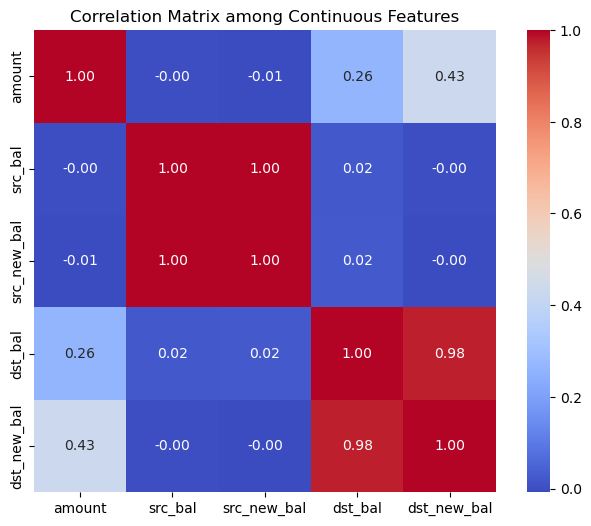

In [74]:
corr_matrix = df[continuous_features].corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix among Continuous Features")
plt.show()



จากกราฟแสดงให้เห็นว่า `scr_bal` และ `scr_new_bal` มีความสัมพันธ์สูงมาก (r = 1.00)
และ `dst_bal` กับ `dst_new_bal` ก็มีความสัมพันธ์สูงเช่นกัน (r = 0.98)
คู่ฟีเจอร์เหล่านี้แทบจะซ้ำกันทางข้อมูล เนื่องจากแสดงยอดคงเหลือก่อนและหลังธุรกรรมของบัญชีเดียวกัน
ดังนั้นในขั้นตอน Feature Selection ควรพิจารณาตัดออก 1 ตัวจากแต่ละคู่ (ตัด `scr_new_bal` และ `dst_new_bal`)
เพื่อหลีกเลี่ยงปัญหา multicollinearity และลดความซ้ำซ้อนของข้อมูลในโมเดล

Cramér’s V (Categorical Features)

In [73]:
categorical_features = ['transac_type', 'is_flagged_fraud', 'hour_of_day']

def cramers_v(x, y):
    contingency = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency)[0]
    n = contingency.sum().sum()
    phi2 = chi2 / n
    r, k = contingency.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

for i in range(len(categorical_features)):
    for j in range(i + 1, len(categorical_features)):
        v = cramers_v(df[categorical_features[i]], df[categorical_features[j]])
        print(f"{categorical_features[i]} vs {categorical_features[j]} → Cramér’s V = {v:.3f}")


transac_type vs is_flagged_fraud → Cramér’s V = 0.005
transac_type vs hour_of_day → Cramér’s V = 0.070
is_flagged_fraud vs hour_of_day → Cramér’s V = 0.008


จากการวิเคราะห์ความสัมพันธ์ระหว่างฟีเจอร์เชิงหมวดหมู่ด้วยค่า Cramér’s V พบว่า
- `transac_type` vs `is_flagged_fraud` = 0.005 → แทบไม่มีความสัมพันธ์
- `transac_type` vs `hour_of_day` = 0.070 → ความสัมพันธ์ต่ำมาก (ธุรกรรมแต่ละประเภทเกิดกระจายทั่วทั้งวัน)
- `is_flagged_fraud` vs `hour_of_day` = 0.008 → ไม่มีความสัมพันธ์ทางสถิติ

ผลลัพธ์นี้ชี้ว่า ฟีเจอร์เชิงหมวดหมู่ไม่มีความสัมพันธ์กันอย่างมีนัยสำคัญทางสถิติ
โดยเฉพาะฟีเจอร์ `is_flagged_fraud` ซึ่งมีแนวโน้มว่าไม่ได้สะท้อนพฤติกรรมการฉ้อโกงจริง
แต่เป็นเพียงระบบตรวจจับหรือแจ้งเตือนอัตโนมัติที่ไม่สัมพันธ์กับเวลาหรือประเภทธุรกรรม ซึ่งยืนยันผลที่ได้จากการวิเคราะห์ข้อมูลของ `is_flagged_fraud` กับ target ในขั้นตอนก่อนหน้า ดังนั้นจึงพิจารณาตัดตัวแปรนี้ทิ้ง

# Final Feature Selection Summary

# Get Started
หลังจากโคลน git นี้มาแล้วให้ติดตั้ง
